# Model Selection

This notebook compares multiple machine learning models
to identify the best-performing model for predicting
customer conversion.

Models evaluated:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/conversion_marketing.csv")
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


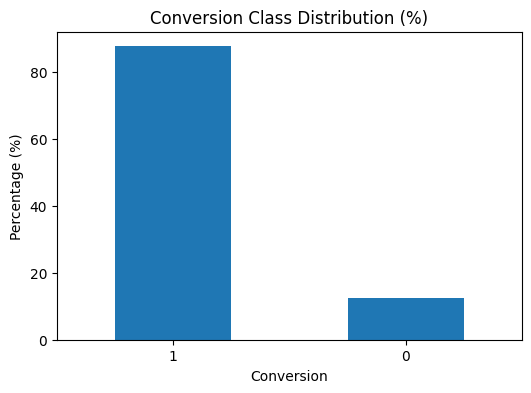

Conversion
1    87.65
0    12.35
Name: proportion, dtype: float64

In [27]:
conversion_counts = df["Conversion"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
conversion_counts.plot(kind="bar")
plt.ylabel("Percentage (%)")
plt.title("Conversion Class Distribution (%)")
plt.xticks(rotation=0)
plt.show()

conversion_counts


## Define Target and Features

In [28]:
X = df.drop("Conversion", axis=1)
y = df["Conversion"]


## Train-Test Split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Preprocessing Pipeline

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


C:\Users\Indrajith\AppData\Local\Temp\ipykernel_7948\1264741059.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=["object"]).columns


## Define Models

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


## Train & Compare Using ROC-AUC

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc

results

d:\Dev\ml-conversion-model-azure-deployment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [20:52:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Logistic Regression': 0.8354911454055534,
 'Decision Tree': 0.7291027248231243,
 'Random Forest': 0.9542680730269889,
 'XGBoost': 0.9732380870041355}

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = pipe.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Precision: 0.946712802768166
Recall: 0.9757489300998573
F1 Score: 0.9610115911485775


In [34]:
import pandas as pd

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["ROC-AUC"])
results_df.sort_values(by="ROC-AUC", ascending=False)


,ROC-AUC
XGBoost,0.973238
Random Forest,0.954268
Logistic Regression,0.835491
Decision Tree,0.729103


### XGBoost selected as final production model due to highest ROC-AUC performance.